### **IMPORTS & DOWNLOADS**


In [192]:
# Core Python libraries
import os
import time
from IPython.display import clear_output, Image, display, HTML

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Google Colab (if running in Colab)
from google.colab import drive

#MOUNT AND R/W DRIVE
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/Weights/best_model.pth"

#GPU or CPU  device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#download data
if not os.path.exists("data.hdf5"):
    !gdown https://drive.google.com/uc?id=1gl5W5PexON0wBfajUTPEkd9AiEnHo4rL -O data.hdf5


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


### **INITIALISE VARIABLES**

In [181]:
# Initialize
lr = 0.0001
batch_size = 64
best_loss = float("inf")
patience_counter = 0
patience = 50

### **LOAD DATA/PREPROCESSING/CREATE DATASET**

In [182]:
# Load dataset NumPy Method
# log_H2O  log_CO2  log_CH4  log_CO  log_NH3

# open hdf5
ds = xr.open_dataset("data.hdf5")


rah='log_H2O'
rahh=rah[4:]

label_names = ['log_H2O']
labels = ds[label_names]
labels_np = labels.to_array().values.T
print(labels_np.shape)
spectra_np = ds['spectrum'].values
print(spectra_np.shape)

train_dataset = TensorDataset(torch.Tensor(spectra_np), torch.Tensor(labels_np))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(type(labels))
ds



(73113, 1)
(73113, 52)
<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset> Size: 263MB
Dimensions:                 (wavelength: 52, sample: 73113, parameter: 6,
                             quartile: 3, species: 5)
Coordinates:
  * wavelength              (wavelength) float64 416B 0.55 0.7 ... 6.814 7.276
  * sample                  (sample) int64 585kB 74589 22241 ... 21258 13523
  * parameter               (parameter) <U13 312B 'planet_temp_k' ... 'log_NH3'
  * quartile                (quartile) <U2 24B 'q1' 'q2' 'q3'
  * species                 (species) <U3 60B 'H2O' 'CO2' 'CH4' 'CO' 'NH3'
Data variables: (12/22)
    bin_width               (wavelength) float64 416B ...
    spectrum                (sample, wavelength) float64 30MB 0.00383 ... 0.0...
    noise                   (sample, wavelength) float64 30MB ...
    planet_temp_k           (sample) float64 585kB ...
    log_H2O                 (sample) float64 585kB -5.09 -7.361 ... -5.493
    log_CO2                 (sample) float64 585kB ...
    ...                      ...
    planet_radius_m         (sample) float64 585kB ...
    planet_surface_gravity  (sample) float64 585kB ...
    valid_quartiles         (sample) bool 73kB ...
    parameter_quartiles     (sample, parameter, quartile) float64 11MB ...
    contributions           (sample, species, wavelength) float64 152MB ...
    clean_forward_model     (sample, wavelength) float64 30MB ...

### **VISUALISE DATA**

######################################################################
 Aundance of log_H2O in planetary atmosphere for planet 0 is -6.4848
######################################################################


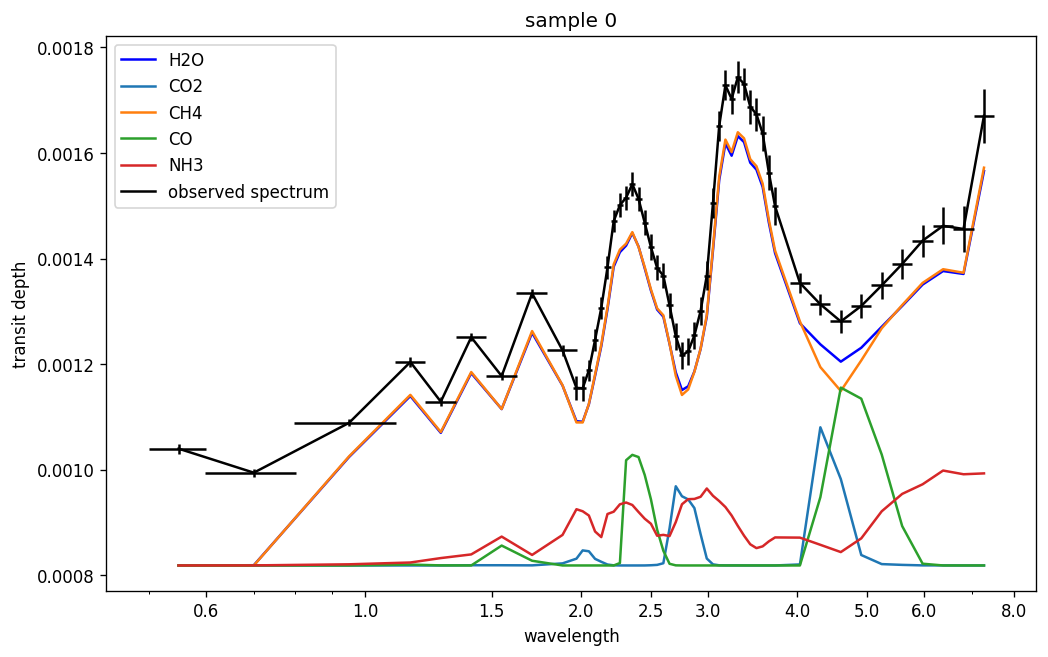

In [183]:
i = 0

plt.figure(figsize=(10, 6), dpi=120)
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['H2O']).values.T, label='H2O', color = 'b')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['CO2']).values.T, label='CO2')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['CH4']).values.T, label='CH4')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['CO']).values.T, label='CO')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['NH3']).values.T, label='NH3')
plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )


plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()


# print the species present in the sample
s_ = rah
print("#"*70)
print(f" Aundance of {s_} in planetary atmosphere for planet {i} is {ds[s_].sel(sample=i).values:.4f}")
print("#"*70)

# 🧠 Creating the Neural Network Model

This is where we will define the architecture of the model that we are going to train



In [184]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()

        # Increased layer width and depth
        self.fc1 = nn.Linear(52, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.05)  # Slightly increased

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.05)

        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.05)

        self.fc4 = nn.Linear(128, 32)  # Extra FC layer
        self.fc5 = nn.Linear(32, 1)  # Output layer

        self._initialize_weights()

    def forward(self, x):
        x = torch.nn.functional.silu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.nn.functional.silu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.nn.functional.silu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = torch.nn.functional.silu(self.fc4(x))  # Extra layer
        x = self.fc5(x)

        return x

    def _initialize_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]:
            init.kaiming_normal_(layer.weight, nonlinearity='relu', mode='fan_out')
            init.constant_(layer.bias, 0)


class ImprovedDeeperModel(nn.Module):
    def __init__(self):
        super(ImprovedDeeperModel, self).__init__()
        self.shortcut_proj = nn.Linear(1024, 512)

        self.fc1 = nn.Linear(52, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.05)

        self.fc2 = nn.Linear(1024, 768)
        self.bn2 = nn.BatchNorm1d(768)
        self.dropout2 = nn.Dropout(0.05)

        self.fc3 = nn.Linear(768, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.1)  # <- middle dropout a bit higher

        self.fc4 = nn.Linear(512, 384)
        self.bn4 = nn.BatchNorm1d(384)
        self.dropout4 = nn.Dropout(0.1)

        self.fc5 = nn.Linear(384, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.1)

        self.fc6 = nn.Linear(256, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.dropout6 = nn.Dropout(0.05)  # -> slightly lower again

        self.fc7 = nn.Linear(128, 64)
        self.bn7 = nn.BatchNorm1d(64)
        self.dropout7 = nn.Dropout(0.05)

        self.fc8 = nn.Linear(64, 32)
        self.bn8 = nn.BatchNorm1d(32)
        self.dropout8 = nn.Dropout(0.05)

        self.fc9 = nn.Linear(32, 1)  # Output

        self._initialize_weights()

    def forward(self, x):
        # Forward pass with optional tiny residual skip after first 3 layers
        x1 = F.silu(self.bn1(self.fc1(x)))
        x1 = self.dropout1(x1)

        x2 = F.silu(self.bn2(self.fc2(x1)))
        x2 = self.dropout2(x2)

        x3 = F.silu(self.bn3(self.fc3(x2)))
        x3 = self.dropout3(x3)

        shortcut = self.shortcut_proj(x1)  # project x1
        x3 = x3 + shortcut * 0.1


        x4 = F.silu(self.bn4(self.fc4(x3)))
        x4 = self.dropout4(x4)

        x5 = F.silu(self.bn5(self.fc5(x4)))
        x5 = self.dropout5(x5)

        x6 = F.silu(self.bn6(self.fc6(x5)))
        x6 = self.dropout6(x6)

        x7 = F.silu(self.bn7(self.fc7(x6)))
        x7 = self.dropout7(x7)

        x8 = F.silu(self.bn8(self.fc8(x7)))
        x8 = self.dropout8(x8)

        out = self.fc9(x8)

        return out

    def _initialize_weights(self):
        for layer in [
            self.fc1, self.fc2, self.fc3, self.fc4,
            self.fc5, self.fc6, self.fc7, self.fc8, self.fc9
        ]:
            init.kaiming_normal_(layer.weight, nonlinearity='relu', mode='fan_out')
            init.constant_(layer.bias, 0)


#optim & scheduler

In [193]:
model = ImprovedDeeperModel().to(device)
model.to(device)
criterion = nn.MSELoss().to(device)

#optimizer (select one)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

#optimizer = optim.Adam(model.parameters(), lr=lr)


#scheduler (select one)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',          # because you want to minimize loss
    factor=0.5,          # reduce lr by a factor of 0.5
    patience=5,          # wait 5 epochs of no improvement
    threshold=0.001,     # minimum change to qualify as an improvement
    threshold_mode='rel',# relative comparison (recommended)
    cooldown=2,          # wait 2 epochs after lr reduction before resuming normal operation
    min_lr=1e-6,         # don't let lr fall below 1e-6
    verbose=True         # print updates
)





/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Visualising the training process + functions

Lets visualise this like we were doing in class. by creating some functions which plot the data.

In [186]:
def plot_loss(losses, epoch):

    losses = np.array(losses)

    plt.figure()
    plt.plot(losses, "k-")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'training loss\nepoch: {epoch}')

    plt.yscale('log')

    plt.ylim(losses.mean() - 3 * losses.std(), 4)

    plt.savefig('training_loss.png')
    plt.close()

In [187]:
def plot_predictions(predictions, labels, epoch):

    # make sure plot is square
    plt.figure(figsize=(5, 5))
    plt.plot(labels, predictions, "k.", label='predictions')
    plt.plot(labels, labels, "r--", label='Ground Truth')
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.title(f'predictions for {rahh}\nepoch: {epoch}')

    plt.xlim(labels.min(), labels.max())
    plt.ylim(labels.min(), labels.max())

    plt.savefig('predictions.png')
    plt.close()

In [188]:
def save_checkpoint(epoch, model, optimizer, scheduler, loss, save_path=save_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),  # <-- ADD THIS
        'loss': loss
    }, save_path)
    print(f"🔥 Saved New Best Model at Epoch {epoch} with Loss: {loss}")



In [189]:
def load_checkpoint(model, optimizer, scheduler, path=save_path):
    if not os.path.exists(path):
        print("❌ No checkpoint found. Starting from scratch.")
        return 0, float('inf')
    try:
        checkpoint = torch.load(path, map_location=torch.device('cpu'),weights_only=False)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])  # <-- ADD THIS
        print(f"✅ Loaded Best Model from Epoch {checkpoint['epoch']} with Loss: {checkpoint['loss']}")
        return checkpoint["epoch"], checkpoint["loss"]
    except RuntimeError as e:
        print("⚠️ Checkpoint loading failed due to model mismatch or architecture change. Starting from scratch.")
        print(e)
        return 0, float('inf')


In [190]:
class EarlyStopping:
    def __init__(self, patience=100, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def check_early_stop(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Stopping early at epoch {epoch}!")
                return True
        return False

# 🚴‍♀️ Training for real




In [ ]:
from IPython.display import HTML, display, Javascript
import time, os

# --- Setup ---
filename_loss = '/content/training_loss.png'
filename_predictions = '/content/predictions.png'
last_mtime_loss = None
last_mtime_predictions = None

# --- Display once at the start ---
def get_img_html(filepath, img_id, width='25%'):
    return f'''
    <img id="{img_id}" src="/files{filepath}"
         style="width: {width}; margin-right: 10px; transition: opacity 0.8s ease; opacity: 1;">
    '''


html = f"""
<div style="display: flex; flex-direction: row; align-items: center;">
    {get_img_html(filename_loss, 'loss_img')}
    {get_img_html(filename_predictions, 'predictions_img')}
</div>
"""
display(HTML(html))

# --- Refresh images function ---
def refresh_images():
    timestamp = int(time.time() * 1000)
    js_code = f"""
    function preloadAndSwap(id, filepath) {{
        var img = document.getElementById(id);
        var newImg = new Image();
        newImg.src = filepath + "?{timestamp}";
        img.style.opacity = 0;  // Start fading out
        newImg.onload = function() {{
            setTimeout(function() {{
                img.src = newImg.src;  // Swap only when fully loaded
                img.style.opacity = 1; // Fade in
            }}, 550);  // Wait for fade-out animation to finish
        }};
    }}
    preloadAndSwap('loss_img', '/files{filename_loss}');
    preloadAndSwap('predictions_img', '/files{filename_predictions}');
    """
    display(Javascript(js_code))



# --- Your training loop ---
batch_losses = []
epoch_losses = []
patience_counter = 0
patience = 50

try:
    start_epoch, best_loss = load_checkpoint(model, optimizer, scheduler)
    last_epoch = start_epoch
    start_epoch = 0
except RuntimeError as e:
    print("⚠️ Checkpoint loading failed due to model mismatch. Starting from scratch.")
    print(e)
    start_epoch = 0
    best_loss = float('inf')

early_stopping = EarlyStopping(patience=patience)

# 🚀 TRAINING LOOP
best_epoch_loss = best_loss  # Track best loss

for epoch in range(start_epoch, 1000):
    model.train()
    batch_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        batch_losses.append(loss.item())

    epoch_loss = np.mean(batch_losses)
    epoch_losses.append(epoch_loss)
    batch_losses = []

    # 💾 Save the best model based on VALIDATION loss
    if epoch_loss < best_epoch_loss:
        best_epoch_loss = epoch_loss
        save_checkpoint(epoch + last_epoch, model, optimizer, scheduler, epoch_loss)
        print(f"🔥 Saved New Best Model at Epoch {epoch} with Loss: {epoch_losses[-1]}")

    # Adjust learning rate
    scheduler.step(epoch_losses[-1])
    warmup_epochs = 4
    if epoch < warmup_epochs:
        for g in optimizer.param_groups:
            g['lr'] = lr * (epoch + 1) / warmup_epochs  # Linearly increase
    plot_loss(epoch_losses, epoch)
    plot_predictions(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy(), epoch)

    # --- Check if images updated ---
    updated = False
    mtime_loss = os.path.getmtime(filename_loss)
    if mtime_loss != last_mtime_loss:
        last_mtime_loss = mtime_loss
        updated = True

    mtime_predictions = os.path.getmtime(filename_predictions)
    if mtime_predictions != last_mtime_predictions:
        last_mtime_predictions = mtime_predictions
        updated = True

    # --- Refresh images if updated ---
    if updated:
        refresh_images()

    # 📊 Logging
    print(f"Epoch {epoch}, Loss: {epoch_losses[-1]}")

    # ⏹ Early stopping
    if early_stopping.check_early_stop(epoch_loss):
        print(f"⏹ Stopping Early at Epoch {epoch} (No Improvement for {patience} epochs)")
        break


✅ Loaded Best Model from Epoch 116 with Loss: 0.6647711299874756
🔥 Saved New Best Model at Epoch 116 with Loss: 0.6602601000252045
🔥 Saved New Best Model at Epoch 0 with Loss: 0.6602601000252045


<IPython.core.display.Javascript object>

Epoch 0, Loss: 0.6602601000252045
🔥 Saved New Best Model at Epoch 117 with Loss: 0.6397710330425807
🔥 Saved New Best Model at Epoch 1 with Loss: 0.6397710330425807


<IPython.core.display.Javascript object>

Epoch 1, Loss: 0.6397710330425807


<IPython.core.display.Javascript object>

Epoch 2, Loss: 0.6807133517474953


<IPython.core.display.Javascript object>

Epoch 3, Loss: 0.7311557447138525


<IPython.core.display.Javascript object>

Epoch 4, Loss: 0.7680352178719204


<IPython.core.display.Javascript object>

Epoch 5, Loss: 0.7704899147583117


<IPython.core.display.Javascript object>

Epoch 6, Loss: 0.7656857524383308


<IPython.core.display.Javascript object>

Epoch 7, Loss: 0.7683101794173189


<IPython.core.display.Javascript object>

Epoch 8, Loss: 0.7036771592036319


<IPython.core.display.Javascript object>

Epoch 9, Loss: 0.691460779697772


<IPython.core.display.Javascript object>

Epoch 10, Loss: 0.6739397974308394


<IPython.core.display.Javascript object>

Epoch 11, Loss: 0.6780533192847136


<IPython.core.display.Javascript object>

Epoch 12, Loss: 0.6766937647669959


<IPython.core.display.Javascript object>

Epoch 13, Loss: 0.694451028932528


<IPython.core.display.Javascript object>

Epoch 14, Loss: 0.6717727213628649


<IPython.core.display.Javascript object>

Epoch 15, Loss: 0.6708389225229295
🔥 Saved New Best Model at Epoch 132 with Loss: 0.6267069433982813
🔥 Saved New Best Model at Epoch 16 with Loss: 0.6267069433982813


<IPython.core.display.Javascript object>

Epoch 16, Loss: 0.6267069433982813
🔥 Saved New Best Model at Epoch 133 with Loss: 0.614662756587681
🔥 Saved New Best Model at Epoch 17 with Loss: 0.614662756587681


<IPython.core.display.Javascript object>

Epoch 17, Loss: 0.614662756587681


<IPython.core.display.Javascript object>

Epoch 18, Loss: 0.6194850718464021


<IPython.core.display.Javascript object>

Epoch 19, Loss: 0.6247757892283242


<IPython.core.display.Javascript object>

Epoch 20, Loss: 0.6210943221237611


<IPython.core.display.Javascript object>

Epoch 21, Loss: 0.615428401077409


<IPython.core.display.Javascript object>

Epoch 22, Loss: 0.6196747202416417
🔥 Saved New Best Model at Epoch 139 with Loss: 0.611764251208055
🔥 Saved New Best Model at Epoch 23 with Loss: 0.611764251208055


<IPython.core.display.Javascript object>

Epoch 23, Loss: 0.611764251208055
🔥 Saved New Best Model at Epoch 140 with Loss: 0.6097290139264009
🔥 Saved New Best Model at Epoch 24 with Loss: 0.6097290139264009


<IPython.core.display.Javascript object>

Epoch 24, Loss: 0.6097290139264009
🔥 Saved New Best Model at Epoch 141 with Loss: 0.609465562739293
🔥 Saved New Best Model at Epoch 25 with Loss: 0.609465562739293


<IPython.core.display.Javascript object>

Epoch 25, Loss: 0.609465562739293
🔥 Saved New Best Model at Epoch 142 with Loss: 0.6045660275643266
🔥 Saved New Best Model at Epoch 26 with Loss: 0.6045660275643266


<IPython.core.display.Javascript object>

Epoch 26, Loss: 0.6045660275643266


<IPython.core.display.Javascript object>

Epoch 27, Loss: 0.6070687502805121


<IPython.core.display.Javascript object>

Epoch 28, Loss: 0.606001732445608
🔥 Saved New Best Model at Epoch 145 with Loss: 0.6002676359859351
🔥 Saved New Best Model at Epoch 29 with Loss: 0.6002676359859351


<IPython.core.display.Javascript object>

Epoch 29, Loss: 0.6002676359859351
🔥 Saved New Best Model at Epoch 146 with Loss: 0.5987198472101232
🔥 Saved New Best Model at Epoch 30 with Loss: 0.5987198472101232


<IPython.core.display.Javascript object>

Epoch 30, Loss: 0.5987198472101232


<IPython.core.display.Javascript object>

Epoch 31, Loss: 0.607583468589257


<IPython.core.display.Javascript object>

Epoch 32, Loss: 0.6043260456409145


<IPython.core.display.Javascript object>

Epoch 33, Loss: 0.6021773520130289


<IPython.core.display.Javascript object>

Epoch 34, Loss: 0.6044291764732421
🔥 Saved New Best Model at Epoch 151 with Loss: 0.5919366597034174
🔥 Saved New Best Model at Epoch 35 with Loss: 0.5919366597034174


<IPython.core.display.Javascript object>

Epoch 35, Loss: 0.5919366597034174


<IPython.core.display.Javascript object>

Epoch 36, Loss: 0.6028656589416486


<IPython.core.display.Javascript object>

Epoch 37, Loss: 0.5965681502095254


<IPython.core.display.Javascript object>

Epoch 38, Loss: 0.6013362028832406


<IPython.core.display.Javascript object>

Epoch 39, Loss: 0.6011683258667184


<IPython.core.display.Javascript object>

Epoch 40, Loss: 0.6043473800362356


<IPython.core.display.Javascript object>

Epoch 41, Loss: 0.5986567310278392
🔥 Saved New Best Model at Epoch 158 with Loss: 0.571163396444742
🔥 Saved New Best Model at Epoch 42 with Loss: 0.571163396444742


<IPython.core.display.Javascript object>

Epoch 42, Loss: 0.571163396444742
🔥 Saved New Best Model at Epoch 159 with Loss: 0.5684612055854221
🔥 Saved New Best Model at Epoch 43 with Loss: 0.5684612055854221


<IPython.core.display.Javascript object>

Epoch 43, Loss: 0.5684612055854221
🔥 Saved New Best Model at Epoch 160 with Loss: 0.5671808282768945
🔥 Saved New Best Model at Epoch 44 with Loss: 0.5671808282768945


<IPython.core.display.Javascript object>

Epoch 44, Loss: 0.5671808282768945
🔥 Saved New Best Model at Epoch 161 with Loss: 0.5575150690470885
🔥 Saved New Best Model at Epoch 45 with Loss: 0.5575150690470885


<IPython.core.display.Javascript object>

Epoch 45, Loss: 0.5575150690470885


<IPython.core.display.Javascript object>

Epoch 46, Loss: 0.5752383546409957


<IPython.core.display.Javascript object>

Epoch 47, Loss: 0.561171402077558
🔥 Saved New Best Model at Epoch 164 with Loss: 0.5554816638912324
🔥 Saved New Best Model at Epoch 48 with Loss: 0.5554816638912324


<IPython.core.display.Javascript object>

Epoch 48, Loss: 0.5554816638912324


<IPython.core.display.Javascript object>

Epoch 49, Loss: 0.5632792345964377


<IPython.core.display.Javascript object>

Epoch 50, Loss: 0.5617862431265654


<IPython.core.display.Javascript object>

Epoch 51, Loss: 0.5630388282441509


<IPython.core.display.Javascript object>

Epoch 52, Loss: 0.5667528054324139


<IPython.core.display.Javascript object>

Epoch 53, Loss: 0.5581388586540548


<IPython.core.display.Javascript object>

Epoch 54, Loss: 0.560960882644015
🔥 Saved New Best Model at Epoch 171 with Loss: 0.5542496202655351
🔥 Saved New Best Model at Epoch 55 with Loss: 0.5542496202655351


<IPython.core.display.Javascript object>

Epoch 55, Loss: 0.5542496202655351
🔥 Saved New Best Model at Epoch 172 with Loss: 0.5493679746776845
🔥 Saved New Best Model at Epoch 56 with Loss: 0.5493679746776845


<IPython.core.display.Javascript object>

Epoch 56, Loss: 0.5493679746776845
🔥 Saved New Best Model at Epoch 173 with Loss: 0.5458425950203564
🔥 Saved New Best Model at Epoch 57 with Loss: 0.5458425950203564


<IPython.core.display.Javascript object>

Epoch 57, Loss: 0.5458425950203564
🔥 Saved New Best Model at Epoch 174 with Loss: 0.5446802654213166
🔥 Saved New Best Model at Epoch 58 with Loss: 0.5446802654213166


<IPython.core.display.Javascript object>

Epoch 58, Loss: 0.5446802654213166
🔥 Saved New Best Model at Epoch 175 with Loss: 0.5420442120296749
🔥 Saved New Best Model at Epoch 59 with Loss: 0.5420442120296749


<IPython.core.display.Javascript object>

Epoch 59, Loss: 0.5420442120296749
🔥 Saved New Best Model at Epoch 176 with Loss: 0.5409296663284093
🔥 Saved New Best Model at Epoch 60 with Loss: 0.5409296663284093


<IPython.core.display.Javascript object>

Epoch 60, Loss: 0.5409296663284093
🔥 Saved New Best Model at Epoch 177 with Loss: 0.538534216198187
🔥 Saved New Best Model at Epoch 61 with Loss: 0.538534216198187


<IPython.core.display.Javascript object>

Epoch 61, Loss: 0.538534216198187
🔥 Saved New Best Model at Epoch 178 with Loss: 0.5318722156897409
🔥 Saved New Best Model at Epoch 62 with Loss: 0.5318722156897409


<IPython.core.display.Javascript object>

Epoch 62, Loss: 0.5318722156897409


<IPython.core.display.Javascript object>

Epoch 63, Loss: 0.5382852921961486


<IPython.core.display.Javascript object>

Epoch 64, Loss: 0.5511735433798971


<IPython.core.display.Javascript object>

Epoch 65, Loss: 0.5448264516661904


<IPython.core.display.Javascript object>

Epoch 66, Loss: 0.5326618405021499


<IPython.core.display.Javascript object>

Epoch 67, Loss: 0.5359098443782653


<IPython.core.display.Javascript object>

Epoch 68, Loss: 0.5397439896930025
🔥 Saved New Best Model at Epoch 185 with Loss: 0.5269198176872282
🔥 Saved New Best Model at Epoch 69 with Loss: 0.5269198176872282


<IPython.core.display.Javascript object>

Epoch 69, Loss: 0.5269198176872282


<IPython.core.display.Javascript object>

Epoch 70, Loss: 0.5353128969056609


<IPython.core.display.Javascript object>

Epoch 71, Loss: 0.5275079106564909


<IPython.core.display.Javascript object>

Epoch 72, Loss: 0.532713912864161
🔥 Saved New Best Model at Epoch 189 with Loss: 0.5266211227247408
🔥 Saved New Best Model at Epoch 73 with Loss: 0.5266211227247408


<IPython.core.display.Javascript object>

Epoch 73, Loss: 0.5266211227247408
🔥 Saved New Best Model at Epoch 190 with Loss: 0.5210904260007102
🔥 Saved New Best Model at Epoch 74 with Loss: 0.5210904260007102


<IPython.core.display.Javascript object>

Epoch 74, Loss: 0.5210904260007102


<IPython.core.display.Javascript object>

Epoch 75, Loss: 0.5270181028913846


<IPython.core.display.Javascript object>

Epoch 76, Loss: 0.5266305974123254


<IPython.core.display.Javascript object>

Epoch 77, Loss: 0.5280735868429366


<IPython.core.display.Javascript object>

Epoch 78, Loss: 0.5342882873844078


<IPython.core.display.Javascript object>

Epoch 79, Loss: 0.5331725114443171


<IPython.core.display.Javascript object>

Epoch 80, Loss: 0.5272130464787871
🔥 Saved New Best Model at Epoch 197 with Loss: 0.5195855586443257
🔥 Saved New Best Model at Epoch 81 with Loss: 0.5195855586443257


<IPython.core.display.Javascript object>

Epoch 81, Loss: 0.5195855586443257


<IPython.core.display.Javascript object>

Epoch 82, Loss: 0.5199275847234334


<IPython.core.display.Javascript object>

Epoch 83, Loss: 0.5235938944528735


<IPython.core.display.Javascript object>

Epoch 84, Loss: 0.5211913009302093
🔥 Saved New Best Model at Epoch 201 with Loss: 0.5193130465864823
🔥 Saved New Best Model at Epoch 85 with Loss: 0.5193130465864823


<IPython.core.display.Javascript object>

Epoch 85, Loss: 0.5193130465864823


# 🚨 If you are working through this at home **stop here**
## We will cover this next session in class

---
### ✍️ Student Task: Lets put these models to the test.

We will now test our best model against some planets that it has not seen before in training! As we train the model, we will calculate the model performance on the seen (train) data, and also on unseen (test) data. This helps us to get a better understanding of the model capabilities.

We need to define a new loss plotting function for testing our competition models as we have an extra dataset to consider

In [ ]:
def plot_loss(losses, test_losses, epoch):

    losses = np.array(losses)
    test_losses = np.array(test_losses)

    plt.figure()
    plt.plot(losses, "k-", label='train loss')
    plt.plot(test_losses, "g-", label='test loss')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'training loss\nepoch: {epoch}')

    plt.yscale('log')
    plt.legend()

    plt.ylim(test_losses.mean() - 3 * test_losses.std(), 4)

    plt.savefig('training_loss.png')
    plt.close()


### 🏁 Competition Time! 🏁

In [ ]:
# split train into train and test - we will use the test data to evaluate the model for our competition score!

tts = [0.8, 0.2]
seed = 42
train_spectra, test_spectra, train_labels, test_labels = train_test_split(spectra_np, labels_np, test_size=tts[1], random_state=seed)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
""")

## ⤵️ Define your best model here

In [ ]:
model = # Your code here...
lr = # Your code here...
batch_size = # Your code here...


# use GPU if available for faster training times
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
elif torch.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

model.to(device)
test_spectra = torch.Tensor(test_spectra).to(device)
test_labels = torch.Tensor(test_labels).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
train_dataset = TensorDataset(torch.Tensor(train_spectra).to(device), torch.Tensor(train_labels).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## ⤵️ Train your competition model here by running this cell

In [ ]:
batch_losses = []
epoch_train_losses = []
epoch_test_losses = []

# train the model
model.train()
for epoch in range(500):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    with torch.no_grad():
        test_outputs = model(torch.Tensor(test_spectra))
        test_loss = criterion(test_outputs, test_labels)

    epoch_test_losses.append(test_loss.item())
    epoch_train_losses.append(np.mean(batch_losses))
    batch_losses = []

    if epoch % 5 == 0:
        plot_loss(epoch_train_losses,epoch_test_losses, epoch)
        plot_predictions(outputs.to('cpu').detach().numpy(), labels.to('cpu').detach().numpy(), epoch)

    if epoch % 20 == 0:
        print(f'epoch {epoch}, train loss {epoch_losses[-1]}, test loss {test_loss.item()}')


In [ ]:
# plot the final predictions
with torch.no_grad():
    test_outputs = model(test_spectra)
    plot_predictions(test_outputs.to('cpu').numpy(), test_labels.to('cpu').numpy(), 'final')

# open predictions.png and display here
plt.imshow(plt.imread('predictions.png'))
plt.axis('off')
plt.show()

In [ ]:
print(f'best test loss: {min(epoch_test_losses)}')
print('---')
print(f'model architecture: {model}')
print(f'learning rate: {lr}')
print(f'batch size: {batch_size}')